A trial ML program on MNIST images. Adapted from TensorFlow Authors example.
Simple, end-to-end, LeNet-5-like convolutional MNIST model example.

In [44]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import gzip
import os
import sys
import time

import numpy
import matplotlib.pyplot as plt
import random as rd
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [92]:
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
WORK_DIRECTORY = '../MNIST_data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 1
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 250  # Number of steps between evaluations.


FLAGS = None

In [94]:
def data_type():
    return tf.float32


def maybe_download(filename):
  """Download the data from Yann's website, unless it's already here."""
  if not tf.gfile.Exists(WORK_DIRECTORY):
    tf.gfile.MakeDirs(WORK_DIRECTORY)
  filepath = os.path.join(WORK_DIRECTORY, filename)
  if not tf.gfile.Exists(filepath):
    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    with tf.gfile.GFile(filepath) as f:
      size = f.size()
    print('Successfully downloaded', filename, size, 'bytes.')
  return filepath


def extract_data(filename, num_images):
  """Extract the images into a 4D tensor [image index, y, x, channels].

  Values are rescaled from [0, 255] down to [-0.5, 0.5].
  """
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
    data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
    data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data


def extract_labels(filename, num_images):
  """Extract the labels into a vector of int64 label IDs."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.int64)
  return labels


def fake_data(num_images):
  """Generate a fake dataset that matches the dimensions of MNIST."""
  data = numpy.ndarray(
      shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS),
      dtype=numpy.float32)
  labels = numpy.zeros(shape=(num_images,), dtype=numpy.int64)
  for image in xrange(num_images):
    label = image % 2
    data[image, :, :, 0] = label - 0.5
    labels[image] = label
  return data, labels


def error_rate(predictions, labels):
  """Return the error rate based on dense predictions and sparse labels."""
  return 100.0 - (
      100.0 *
      numpy.sum(numpy.argmax(predictions, 1) == labels) /
      predictions.shape[0])

In [ ]:
# Main training program
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, 60000)
train_labels = extract_labels(train_labels_filename, 60000)
test_data = extract_data(test_data_filename, 10000)
test_labels = extract_labels(test_labels_filename, 10000)

# Generate a validation set.
validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]
num_epochs = NUM_EPOCHS
train_size = train_labels.shape[0]

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step using the {feed_dict} argument to the Run() call below.
train_data_node = tf.placeholder(
    data_type(),
    shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.int64, shape=(BATCH_SIZE,))
eval_data = tf.placeholder(
    data_type(),
    shape=(EVAL_BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

# The variables below hold all the trainable weights. They are passed an
# initial value which will be assigned when we call:
# {tf.global_variables_initializer().run()}
conv1_weights = tf.Variable(
    tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                        stddev=0.1,
                        seed=SEED, dtype=data_type()))
conv1_biases = tf.Variable(tf.zeros([32], dtype=data_type()))
conv2_weights = tf.Variable(tf.truncated_normal(
    [5, 5, 32, 64], stddev=0.1,
    seed=SEED, dtype=data_type()))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64], dtype=data_type()))
fc1_weights = tf.Variable(  # fully connected, depth 512.
    tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                        stddev=0.1,
                        seed=SEED,
                        dtype=data_type()))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512], dtype=data_type()))
fc2_weights = tf.Variable(tf.truncated_normal([512, NUM_LABELS],
                                            stddev=0.1,
                                            seed=SEED,
                                            dtype=data_type()))
fc2_biases = tf.Variable(tf.constant(
    0.1, shape=[NUM_LABELS], dtype=data_type()))

# We will replicate the model structure for the training subgraph, as well
# as the evaluation subgraphs, while sharing the trainable parameters.
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    # Max pooling. The kernel size spec {ksize} also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
      hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=data_type())
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
      0.01,                # Base learning rate.
      batch * BATCH_SIZE,  # Current index into the dataset.
      train_size,          # Decay step.
      0.95,                # Decay rate.
      staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                         0.9).minimize(loss,
                                                       global_step=batch)

# Predictions for the current training minibatch.
train_prediction = tf.nn.softmax(logits)

# Predictions for the test and validation, which we'll compute less often.
eval_prediction = tf.nn.softmax(model(eval_data))

# Small utility function to evaluate a dataset by feeding batches of data to
# {eval_data} and pulling the results from {eval_predictions}.
# Saves memory and enables this to run on smaller GPUs.
def eval_in_batches(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
      raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = numpy.ndarray(shape=(size, NUM_LABELS), dtype=numpy.float32)
    for begin in xrange(0, size, EVAL_BATCH_SIZE):
      end = begin + EVAL_BATCH_SIZE
      if end <= size:
        predictions[begin:end, :] = sess.run(
            eval_prediction,
            feed_dict={eval_data: data[begin:end, ...]})
      else:
        batch_predictions = sess.run(
            eval_prediction,
            feed_dict={eval_data: data[-EVAL_BATCH_SIZE:, ...]})
        predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

# Create a local session to run the training.
start_time = time.time()
with tf.Session() as sess:
    # Run all the initializers to prepare the trainable parameters.
    tf.global_variables_initializer().run()
    print('Initialized!')
    # Loop through training steps.
    for step in xrange(int(num_epochs * train_size) // BATCH_SIZE):
      # Compute the offset of the current minibatch in the data.
      # Note that we could use better randomization across epochs.
      offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
      batch_data = train_data[offset:(offset + BATCH_SIZE), ...]
      batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
      # This dictionary maps the batch data (as a numpy array) to the
      # node in the graph it should be fed to.
      feed_dict = {train_data_node: batch_data,
                   train_labels_node: batch_labels}
      # Run the optimizer to update weights.
      sess.run(optimizer, feed_dict=feed_dict)
      # print some extra information once reach the evaluation frequency
      if step % EVAL_FREQUENCY == 0:
        # fetch some extra nodes' data
        l, lr, predictions = sess.run([loss, learning_rate, train_prediction],
                                      feed_dict=feed_dict)
        elapsed_time = time.time() - start_time
        start_time = time.time()
        print('Step %d (epoch %.2f), %.1f ms' %
              (step, float(step) * BATCH_SIZE / train_size,
               1000 * elapsed_time / EVAL_FREQUENCY))
        print('Minibatch loss: %.3f, learning rate: %.6f' % (l, lr))
        print('Minibatch error: %.1f%%' % error_rate(predictions, batch_labels))
        print('Validation error: %.1f%%' % error_rate(
            eval_in_batches(validation_data, sess), validation_labels))
        sys.stdout.flush()
      if step % 25 == 0:
            print('.', end=' ')
    # Finally print the result!
    test_error = error_rate(eval_in_batches(test_data, sess), test_labels)
    print('Training complete.\nPost training test error: %.1f%%' % test_error)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Initialized!
Step 0 (epoch 0.00), 9.8 ms
Minibatch loss: 8.334, learning rate: 0.010000
Minibatch error: 85.9%
Validation error: 84.6%
. . . . . . . . 

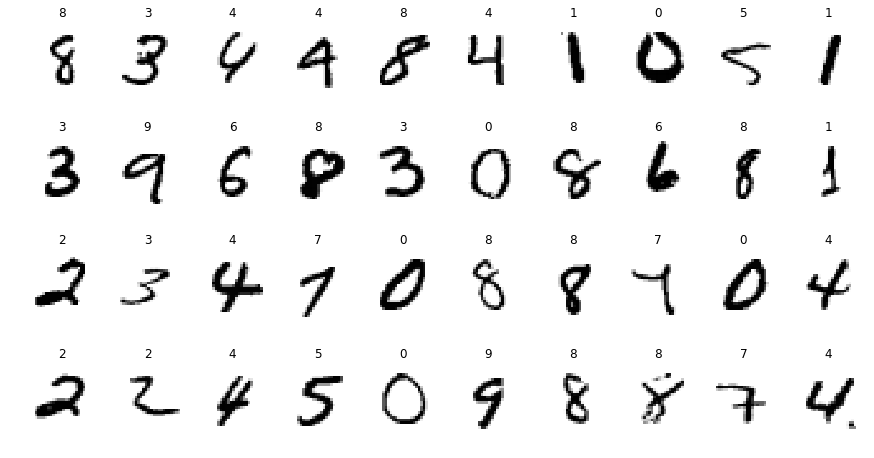

In [91]:
plt.clf
fig, axes=(ax1,ax2) = plt.subplots(4,10,figsize=(15,8))
plt.set_cmap("binary")
for x in axes:
    for ax in x:
        i = rd.randint(0,10000)
        ax.imshow(test_data[i,:,:,0])
        ax.set_title(test_labels[i])
        ax.axis("off")
plt.show()